In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
from pmlb import fetch_data

X, y = fetch_data('294_satellite_image', return_X_y=True)

In [5]:
X.shape

(6435, 36)

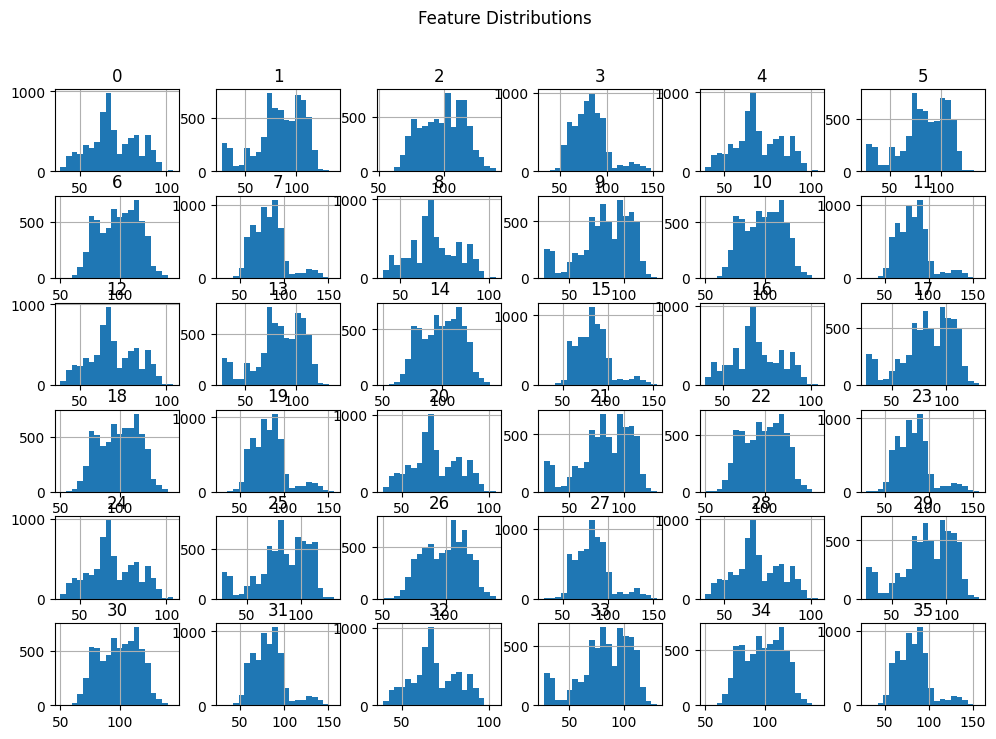

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_df = pd.DataFrame(X)
X_df.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

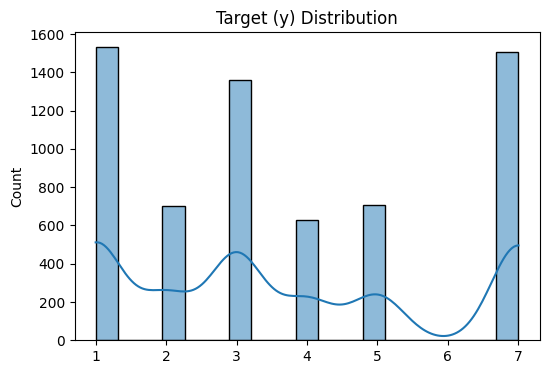

In [7]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

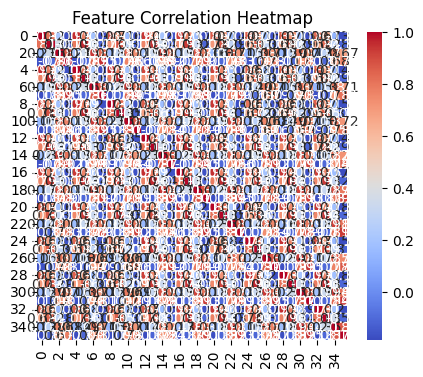

In [8]:
plt.figure(figsize=(5, 4))
corr = X_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [9]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=8, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=8)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.784724                 1.639774             1.344406   
1                  1.871478                 1.667744             1.866974   
2                  1.769440                 1.472780             2.420910   
3                  1.719618                 2.149575             2.047429   
4                  1.808936                 1.734084             1.920428   
5                  2.221691                 1.587353             2.155788   
6                  1.815220                 1.841641             2.157212   
7                  2.345085                 1.834471             2.474569   
mean               1.917024                 1.740928             2.048465   
std                0.232512                 0.205985             0.356302   

      DefaultBART_Rhat_RMSE  
0                  1.720564  
1                  2.205032  
2                  1.884799

In [10]:
rhat_df.to_csv("results/real7_Satellite_rhat.csv", index=False)

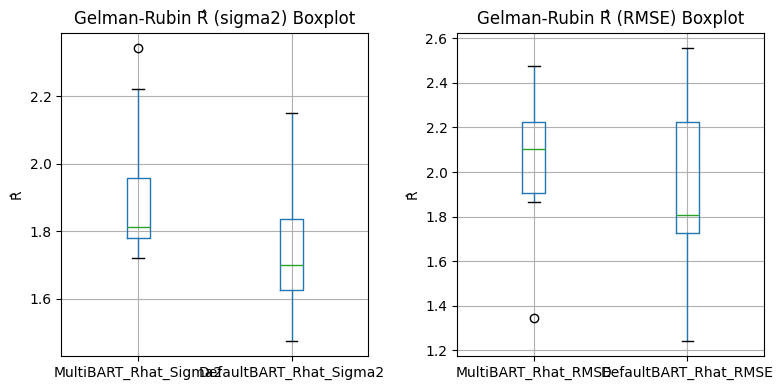

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

test_mse:
      bart_mtmh      bart       btz        rf       xgb
0      0.614411  0.632537  0.557243  0.489757  0.534697
1      0.651870  0.653035  0.641433  0.539908  0.580095
2      0.549342  0.570973  0.612303  0.483001  0.500649
3      0.668609  0.642428  0.664991  0.556418  0.575852
4      0.571927  0.584912  0.608366  0.483305  0.504522
5      0.582456  0.654509  0.644401  0.503560  0.567139
6      0.582952  0.601442  0.638748  0.507003  0.555896
7      0.587971  0.600768  0.618649  0.489314  0.524277
mean   0.601192  0.617576  0.623267  0.506533  0.542891
std    0.040868  0.032170  0.032689  0.027471  0.031391



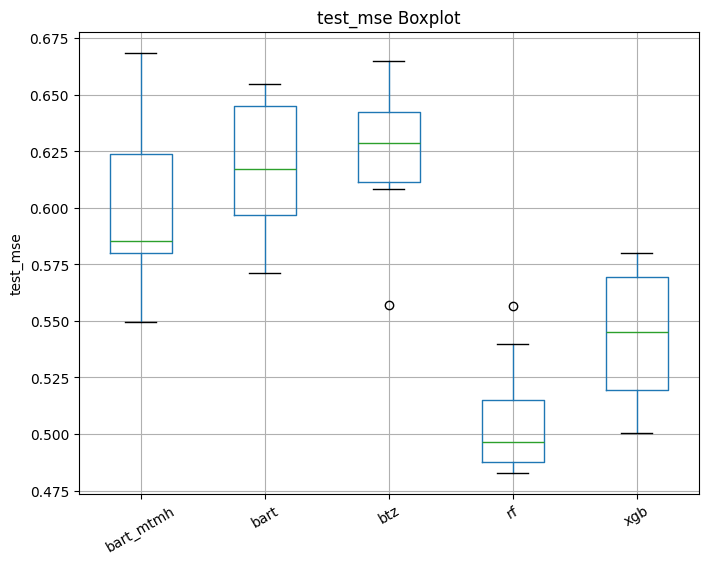

train_mse:
      bart_mtmh      bart       btz        rf       xgb
0      0.203585  0.320797  0.338793  0.071356  0.011611
1      0.196441  0.277191  0.318182  0.068218  0.011267
2      0.200107  0.293747  0.349185  0.071901  0.011581
3      0.189115  0.282117  0.298016  0.067736  0.011723
4      0.194367  0.314234  0.347392  0.067946  0.010618
5      0.204934  0.296715  0.354848  0.069954  0.010860
6      0.201139  0.305280  0.339003  0.070489  0.013329
7      0.181868  0.312629  0.341799  0.068721  0.012514
mean   0.196445  0.300339  0.335902  0.069540  0.011688
std    0.007829  0.015636  0.018783  0.001611  0.000878



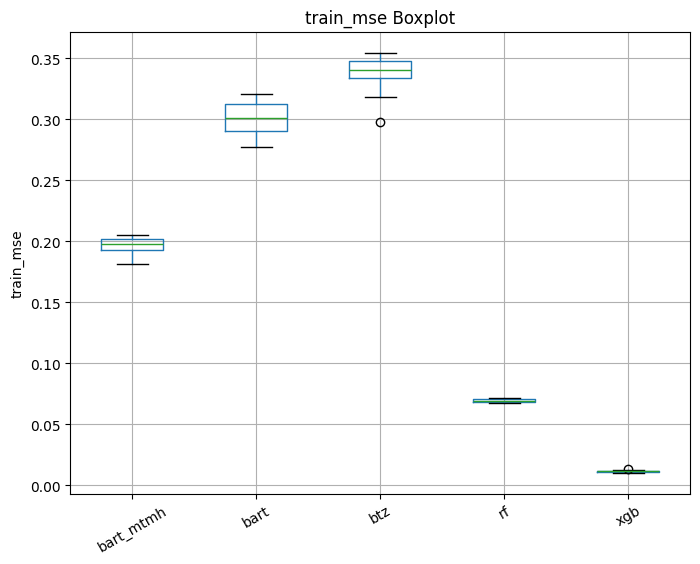

pi_length:
      bart_mtmh      bart       btz
0      2.089812  2.449665  2.833646
1      2.056939  2.330614  2.796288
2      2.081481  2.405081  2.943063
3      2.002216  2.347576  2.753701
4      2.041585  2.475356  2.870175
5      2.117598  2.421008  2.871480
6      2.074095  2.432537  2.849473
7      1.969842  2.501522  2.839496
mean   2.054196  2.420420  2.844665
std    0.048422  0.058803  0.055854



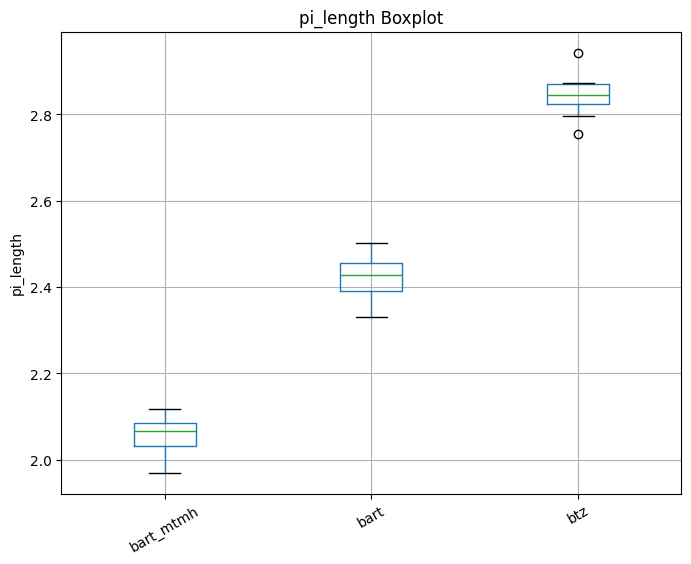

coverage:
      bart_mtmh      bart       btz
0      0.878185  0.898695  0.922933
1      0.866377  0.879428  0.911125
2      0.871970  0.896209  0.917961
3      0.857676  0.883157  0.909260
4      0.868863  0.898073  0.921690
5      0.880050  0.883779  0.921690
6      0.865755  0.888751  0.910503
7      0.850839  0.898695  0.912989
mean   0.867464  0.890848  0.916019
std    0.009797  0.008000  0.005671



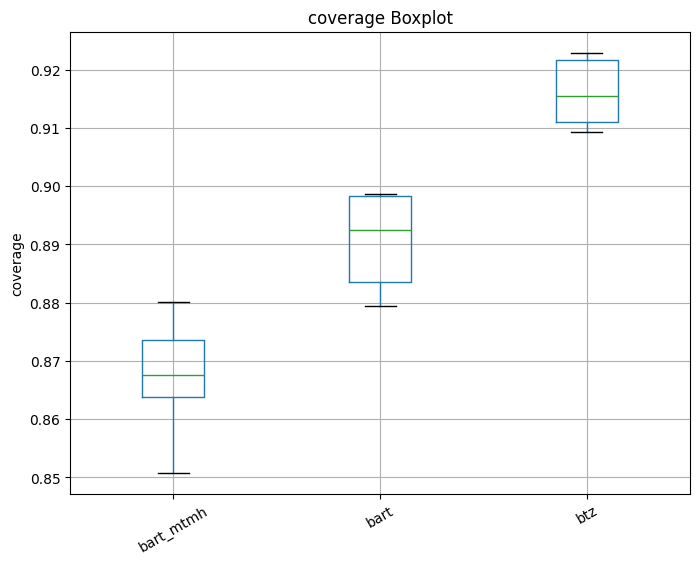

train_time:
       bart_mtmh        bart        btz         rf       xgb
0     395.981516   57.650385  65.082658   8.723856  0.323522
1     401.802836   54.941311  74.219036   8.665493  0.424794
2     395.409910   56.443537  61.407747  12.400887  0.485955
3     399.955558   55.448176  71.429650   7.880341  0.413011
4     413.469703  112.078219  31.494688   6.846513  0.296787
5     399.196227   55.053808  67.954606   7.745044  0.309195
6     397.224627   56.133789  64.764596   9.034688  0.307715
7     394.533109   56.727383  61.441576  12.910482  0.500955
mean  399.696686   63.059576  62.224320   9.275913  0.382742
std     6.087480   19.827304  13.210712   2.200789  0.083875



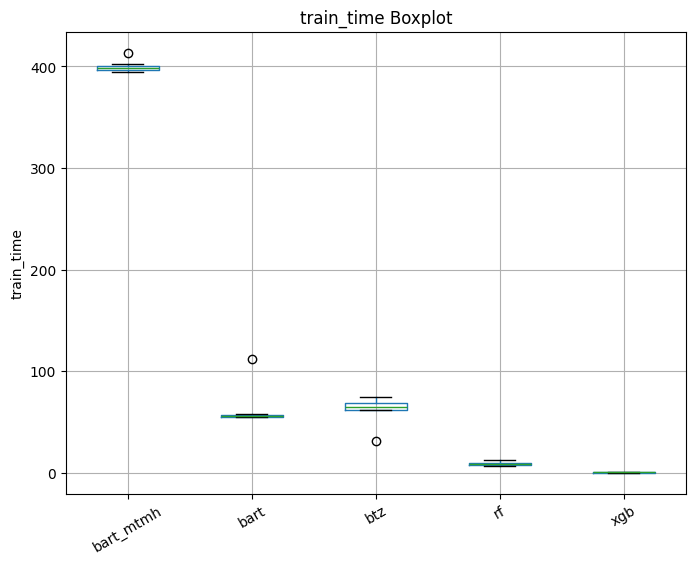

In [12]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=8, n_skip=1000, n_post=1000, n_trees=100, n_jobs=8)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [13]:
for k, v in mse_results.items():
    csv_name = f"results/real7_Satellite_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [14]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real7_Satellite_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 20, 50],
    n_runs=8, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=8
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real7_Satellite_tries.csv", index=False)

c:\Users\ztykk\Phd\BART\bart-playground\.venv\lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [15]:
print(df)

   multi_tries  Rhat_Sigma2  Rhat_RMSE  Test_MSE  Coverage   Train_Time
0            1     1.783064   1.618872  0.608047  0.895121   104.906667
1            5     1.744255   1.591539  0.609675  0.873990   254.594638
2           10     1.917024   2.048465  0.621677  0.871116   409.193012
3           20     2.101947   1.868234  0.630105  0.856122   710.919607
4           50     1.906555   1.966507  0.623920  0.844158  1526.427030
